# Run the LFADS algorithm on an RNN that contextually integrates one of two white noise input streams.

The goal of this tutorial is to learn about LFADS by running the algorithm on a simple data generator, a vanilla recurrent neural network (RNN) that was XXX [trained to integrate one of two white noise input streams](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/Integrator%20RNN%20Tutorial.ipynb).  Running LFADS on this contextual integrator RNN will infer two things:
1. the underlying hidden state of the integrator RNN
2. the white noise input to the integrator RNN.

Doing this will exercise the more complex LFADS architecture that is shown in Figure 5 of the [LFADS paper](https://rdcu.be/6Wji). It's pretty important that you have read at least the introduction of the paper, otherwise you won't understand *why* we are doing what we are doing.

Additionally, we have modified the structure of the prior to be a mixture of gaussians (GMM). In terms of inferring meaningful representation of the data, we would like to see that in a 2 GMM model, one gaussian picks up the variation in one line attractor, while the other gaussian picks up the latent variation in the other line attractor.

In this tutorial we do a few things:
1. Load the contextual integrator RNN data and "spikify" it by treating the hidden units as nonhomogeneous Poisson processes.
2. Explain a bit of the of the LFADS architecture and highlight some of the relevant hyperparameters.
3. Train the LFADS system on the spikified contextual integrator RNN hidden states.
4. Plot a whole bunch of training plots and LFADS outputs!

#### Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Import the tutorial code.

If you are going to actually run the tutorial, you have to install JAX, download the computation thru dynamics github repo, and modify a path. 

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import

import datetime
import h5py
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time

In [2]:
# You must change this to the location of computation-thru-dynamics directory.
HOME_DIR = '/home/sussillo/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import lfads_gmm.lfads as lfads
import lfads_gmm.plotting as plotting
import lfads_gmm.utils as utils
import lfads_gmm.optimize as optimize

### Preliminaries - notes on using JAX

JAX is amazing! It's really, really AMAZING! You program in Numpy/Python and then call a grad on your code, and it'll run speedy on GPUs! It does however have a few quirks and it uses a program deployment model you have to know about. The excited reader should definitely read the [JAX tutorial](https://github.com/google/jax), if they plan on programming with it. 

When using JAX for auto diff, auto batching or compiling, you should always have a two-level mental model in your mind: 
1. At the CPU level, like normal
2. at the device level, for example a GPU. 

Since JAX compiles your code to device, it is very efficient but creates this split.  Thus, for example, we have two NumPY modules kicking around: 'onp' for 'original numpy', which is on the CPU, and np, which is the JAX modified version and runs 'on device'.  This latter version of numpy is enabled to compute gradients and run your code quickly.

So the model then is: initialize variables, seeds, etc, at the CPU level, and *dispatch* a JAX based computation to the device. This all happens naturally whenever you call JAX enabled functions.

Thus one of the first things we do initialize the onp random number generator at the CPU level.

In [3]:
onp_rng = onp.random.RandomState(seed=0) # For CPU-based numpy randomness

----------

### Load the data

You __must__ run through the the integrator RNN [tutorial notebook](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/Integrator%20RNN%20Tutorial.ipynb) on your machine. Don't worry! It's much simpler than this tutorial! :) 

Point to the correct __data__  file for the integrator RNN. Note that the integrator rnn tutorial notebook creates two files, both the parameters file and the data file with examples.

In [4]:
RNN_DATA_FILE = \
     '/tmp/vrnn/contextual_int/trained_data_vrnn_contextual_int_0.00033_2019-10-21_19:33:51.h5'
     #'/tmp/vrnn/contextual_int/trained_data_vrnn_contextual_int_0.00349_2019-10-19_16:37:56.h5'
lfads_dir = '/tmp/lfads/'       # where to save lfads data and parameters to
rnn_type = 'lfads_gmm'
task_type = 'contextual_int'

In [5]:
# Make directories
data_dir = os.path.join(lfads_dir, 'data/')
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Load synthetic data
data_dict = utils.read_file(RNN_DATA_FILE)

### Plot examples and statistics about the integrator RNN data.

Number of data examples:  20480
Number of timesteps:  25
Number of data dimensions:  100


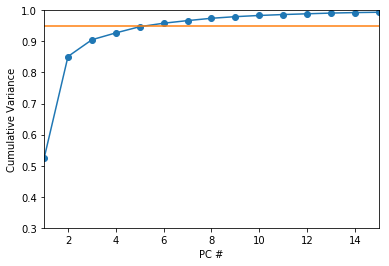

In [6]:
f = plotting.plot_data_pca(data_dict)

The goal of this tutorial is to infer the hiddens (blue), and input to the integrator RNN (umm... also blue).

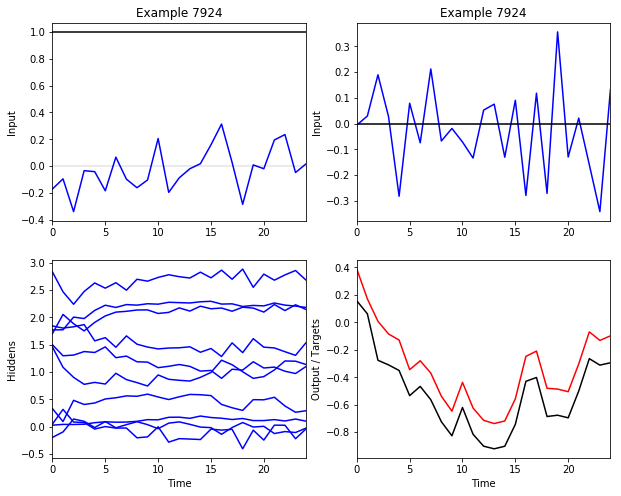

In [7]:
reload(plotting)
f = plotting.plot_data_example(data_dict['inputs'], 
                               data_dict['hiddens'],
                               data_dict['outputs'], 
                               data_dict['targets'])

### Spikify the synthetic data
The output of the integrator rnn is the continuous inputs,
hidden states and outputs of the example.  LFADS is a tool 
to infer underlying factors in spiking neural data, so we 
are going to "spikify" the integrator rnn example hidden states.

Data was generated w/ VRNN w/ tanh, thus $(\mbox{data}+1) / 2 \rightarrow [0,1]$. 
We put those activations between 0 and 1 here and then convert to spikes.

In [8]:
data_dt = 1.0/25.0        # define our dt in a physiological range

# If data is normed between 0 and 1, then a 1 yields this many 
# spikes per second. Pushing this downwards makes the problem harder.
max_firing_rate = 80      
train_fraction = 0.9      # Train with 90% of the synthetic data

renormed_fun = lambda x : (x + 1) / 2.0

renormed_data = renormed_fun(data_dict['hiddens'])

# When dimensions are relevant, I use a variable naming scheme like
# name_dim1xdim2x...  so below, here is the synthetic data with 
# 3 dimensions of batch, time and unit, in that order.
data_bxtxn = utils.spikify_data(renormed_data, onp_rng, data_dt,
                                max_firing_rate=max_firing_rate)
nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)

# utils doesn't know about JAX Device arrays, so convert here.
train_data = np.asarray(train_data)
eval_data = np.asarray(eval_data)

eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

#### Plot the statistics of the data.

40.1829892578125 spikes/second


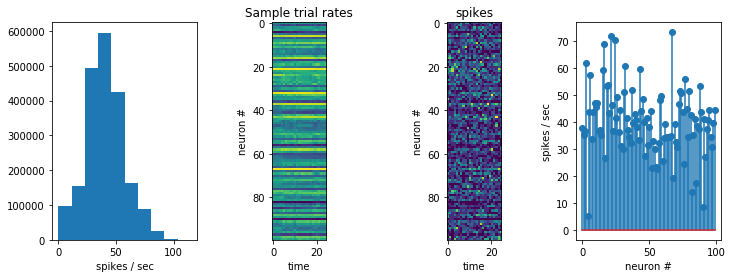

In [9]:
reload(plotting)
f = plotting.plot_data_stats(data_dict, data_bxtxn, data_dt, bidx=3)

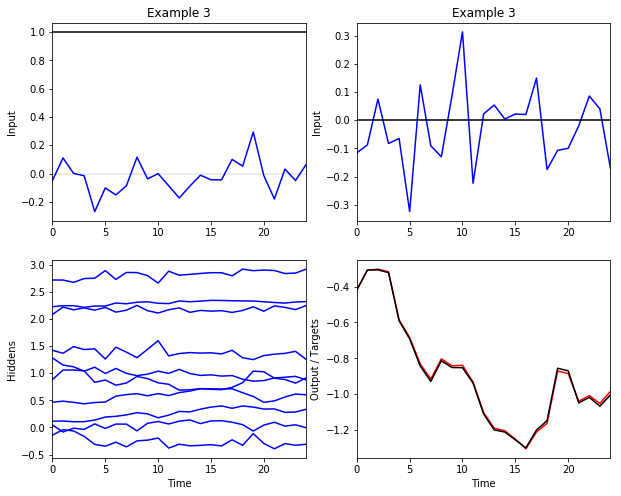

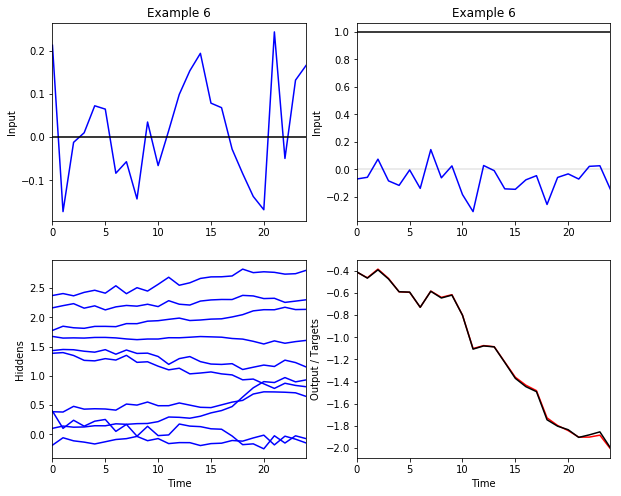

In [10]:
# The indicies (3,6) are just hunting around in the random trials for both contexts.
f = plotting.plot_data_example(data_dict['inputs'], data_dict['hiddens'],
                           data_dict['outputs'], data_dict['targets'], 
                           bidx=3)

f = plotting.plot_data_example(data_dict['inputs'], data_dict['hiddens'],
                           data_dict['outputs'], data_dict['targets'], 
                           bidx=6)

Let's study this single example of a single neuron's true firing rate (red) and the spikified version in the blue stem plot.

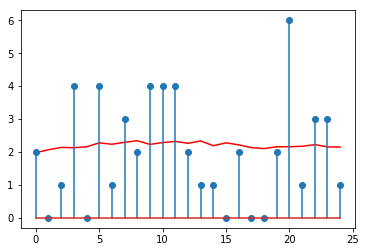

In [11]:
my_example_bidx = eval_data_offset + 0
my_example_hidx = 6
scale = max_firing_rate * data_dt
my_signal = scale*renormed_data[my_example_bidx, :, my_example_hidx]
my_signal_spikified = data_bxtxn[my_example_bidx, :, my_example_hidx]
plt.plot(my_signal, 'r');
plt.stem(my_signal_spikified);

If you were to increase ```max_firing_rate``` to infinity, the stem plot would approach the red line. This plot gives you an idea of how challenging the data set is, at least on single trials. We can think about this a little bit.  If you were to simply filter the spikes, it definitely would not look like the red trace, at this low maximum firing rate. This means that if any technique were to have 

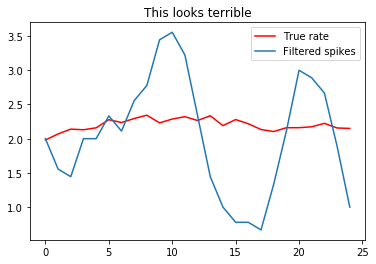

In [12]:
nfilt = 3
my_filtered_spikes = scipy.signal.filtfilt(onp.ones(nfilt)/nfilt, 1, my_signal_spikified)
plt.plot(my_signal, 'r');
plt.plot(my_filtered_spikes);
plt.title("This looks terrible");
plt.legend(('True rate', 'Filtered spikes'));

This would force us to think about ways in which the *population* can be filtered. The first idea is naturally PCA. Perhaps there is a low-d subspace of signal that can be found in the high-variance top PCs. Using the entire trial, it's likely this should do better.

In [13]:
import sklearn
ncomponents = 100
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(onp.reshape(data_bxtxn, [-1, data_dim]))

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

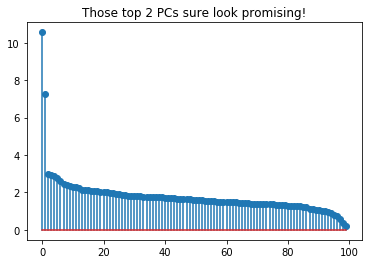

In [14]:
plt.stem(full_pca.explained_variance_)
plt.title('Those top 2 PCs sure look promising!');

In [15]:
ncomponents = 2
pca = sklearn.decomposition.PCA(ncomponents)
pca.fit(onp.reshape(data_bxtxn[0:eval_data_offset,:,:], [-1, data_dim]))
my_example_pca = pca.transform(data_bxtxn[my_example_bidx,:,:])
my_example_ipca = pca.inverse_transform(my_example_pca)

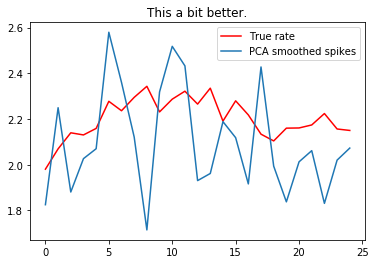

In [16]:
plt.plot(my_signal, 'r')
plt.plot(my_example_ipca[:,my_example_hidx])
plt.legend(('True rate', 'PCA smoothed spikes'))
plt.title('This a bit better.');

So temporal filtering is not great, and spatial filtering helps only a bit.  What to do? The idea LFADS explores is that if you knew the system that generated the data, you would be able separate signal from noise, the signal being what a system can generate, the noise being the rest.

----------------

## LFADS - Latent Factor Analysis via Dynamical Systems


[Link to paper readcube version of the LFADS Nature Methods 2018 paper](https://rdcu.be/6Wji)



### LFADS architecture with inferred inputs

There are 3 variants of the LFADS architecture in the paper
1. autonomous LFADS model (no inferred inputs), Fig. 1a
2. stitched LFADS model for data recorded in different sessions, Fig. 4a
3. non-autonomous LFADS model (with inferred inputs), Fig. 5a

In this tutorial we deal with the non-autonomous model, which I believe is conceptually the most interesting, but also the most challenging to understand.  This tutorial (and the current code), does **NOT** handle stitched data.  Stitching data isn't conceptually hard, but it's a pain to code.  The Tensorflow version of the code handles that, if you need it. 

Here is the non-autonoumous LFADS model architecture: The full description of this model is given in the paper but briefly, the idea is that the data LFADS will 'denoise' or model data generated from a nonlinear, autonoumous system (we call it the data generator and the data generator in this tutorial is the integrator RNN) that receives an input through time. Based on the spiking observations, LFADS will try to pull apart the data into the dynamical system portion, and the input portion, thus the term *inferred inputs*.  I.e. we are trying to infer what inputs would drive a high-d nonlinear system to generate the data you've recorded. Doing this allows the system to model the dynamics much better for systems that are input driven. One final detail is that the model assumes that the spikes are poisson generated from an underlying continuous dynamical system. Of course, this is not true for spiking data from biological neural circuits, but the poisson approximation seems to be ok.

So architecture infers a number of quantities of interest: 
1. initial state to generator (also called initial conditions)
2. inferred inputs to generator - e.g. the LFADS component to learn the white noise in the integrator RNN example
3. dynamical factors - these are like PCs underlying your data
4. rates - a readout from the factors. The rates are really the most intuitive part, which are analogous to filtering your spiking data. 

![](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/lfads_architecture_w_inferred_inputs_3.png)


To begin, let's focus on the *autonomous* version of the architecture, which *excludes the controller RNN*.  The data is put through nonlinear, recurrent **encoders**, and this produces an **initial state distribtion**, which is a per-trial mean and variance to produce random vectors to encode that trial. The initial state of the generator is a randomly drawn vector from this distribution. The **generator** marches through time and at each time point produces **factors** and **rates**, ultimately producing outputs that learn to reproduce your data at the rate level.  


From the perspective on information flow, the automous version of LFADS has a *bottleneck* between your data as inputted into LFADS, and the output, which also tries to learn your data. That bottleneck is the inital state of the generator, a potentially very low-bandwidth bottleneck, as a single vector has to encode a high-d time series. Such a system would be adequate for capturing systems that are (in approximation) autonomous.  For example, motor cortex dynamics during center-out reaches seem extremely well approximated by autonomous dynamics at the sub-second time scale (e.g. Fig 2). However, if you were to perturb the reach by messing with the cursor the animal was using, e.g perturbing cursor location mid-reach, then the motor cortical dynamics of a corrected reach couldn't possibly be autonomous.  In other words, some additional input must have come into the motor cortex and update the system with the information that the cursor had jumped unexpectedly.  This is the experimental setting we setup in Fig. 5.

To compensate for such a scenario, we added a **controller** and **inferred inputs** to the generator portion of LFADS.  In particular, the controller runs in sync with the generator and receives the output of the generator from the last time step (the only "backward" loop in the architecture, aside from using backprop for training with gradient descent).  Thus it it knows what the generator output.  During training, the system learns that there are patterns in the data that cannot be created by the generator autonomously, so learns to compensate by emitting information from the data, through the encoders, through the controller to the generator.  We call this information an inferred input. In our experimental setup, this worked well on two examples: messing with the cursor of an animal making a reach and also for inferring oscillations in the local field potiential (LFP).

Please note that the inferred input system is extremely powerful as it provides a leak from the your input data to the LFADS output on a per-time point basis. As such, one has to make sure that the system  does not pathologically leak all the information from the data trial through LFADS to generate the data trial. LFADS, like all auto-encoders, is at risk of creating a trivial identity function, $x = f(x)$, rather than finding stucture in the data. Thus, we utilize many tricks to avoid this (dropout, KL penalties, and even blocking out information given to the controller from time step t, when decoding time step t.)

### Hyperparameters

In [17]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 128      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 128         # encoder dim
con_dim = 128         # contoller dim

ib_dim = 1            # Dimension of inferred bias. It's treated as an input to generator GRU.
ii_dim = 2            # inferred input dim, we know there is 1 dim in integrator RNN
ii_l2_reg = 0.000     # penalization from deviation of inferred inputs from zero
ii_tavg_reg = 0.001     # penalization from deviation of inferred inputs from zero


gen_dim = 128         # generator dim, should be large enough to generate integrator RNN dynamics
factors_dim = 32      # factors dim, shoudld be large enough to capture most variance of dynamics

do_tanh_latents = True # Large latents can really mess up dynamics, so have an option such that
                       # the generator only sees 
                       #   1. tanh(g0) for initial condition
                       #   2. tanh(ii_t) for inferred input
                       #   3. tanh(ib) for inferred bias
                       # if false, the tanh is not used.

# Numerical stability
var_min = 1e-16 # Don't touch this.

# Optimization HPs that percolates into model
l2reg = 0.001

### Hyperparameters for Priors

As was mentioned above, LFADS is an auto-encoder and auto-encoders typically encode data through some kind of information bottleneck.  The idea is a lot like PCA, if one gets rid unimportant variation, then perhaps meaningful and interesting structure in the data will become apparent.  

More precisely, LFADS is a **variational auto-encoder (VAE)**, which means that the bottleneck is achieved via probabilistic methods.  Namely, each trial intial state is encoded in a per-trial Gaussian distribution called the 'posterior', e.g. initial state parameter's mean and variance are given by $(\mu(\mathbf{x}), \sigma^2(\mathbf{x}))$, where $\mathbf{x}$ is the data.  This then is compared to an **uninformative prior** $(\mu_p, \sigma^2_p)$, where uninformative means the prior is independent of the data, including that trial. A type of distance for distributions is used, called the KL-divergence, to force the initial state Gaussian distribution for each trial to be as close to as possible to a Gaussian that doesn't depend on the trial. This is a part of the **ELBO** - Evidence Lower BOund - that is used to train VAEs.

In summary, one way of explaining VAEs is that they are auto-encoders, but they are attempting to limit the information flow from the input to the output using bottleneck based on probability distributions, basically forcing the generator to generate your data from white noise.  This is doomed to fail if training works, but in the process, it learns a probabilistic generative model of your data.

In this LFADS architecture, there are two posterior distributions, based on the data, and two prior distributions, unrelated to the data.  They are distributions for the initial state, and the distributions for the inferred input.

In [18]:
gmm_size = 2   # number of mixtures in the gaussian.
gmm_num_samples = 50 # number of samples to measure the kl between the gaussian posterior and the gmm prior

In [19]:
lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'gmm_size' : gmm_size, 'gmm_num_samples' : gmm_num_samples,
             'ib_dim' : ib_dim, 'ii_dim' : ii_dim, 
             'ii_l2_reg' : ii_l2_reg, 'ii_tavg_reg' : ii_tavg_reg,
             'do_tanh_latents' : do_tanh_latents,
             'gen_dim' : gen_dim, 
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

#### LFADS Optimization hyperparameters

In [20]:
num_batches = 5000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.015            # initial learning rate
decay_factor = 0.9999      # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.98            # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

#### Create functions for generating data from keys

In [21]:
def data_fun(key, B, data):
    bidxs = random.randint(key, (B,), 0, data.shape[0])
    return data[bidxs]

train_data_fun = lambda key : data_fun(key, lfads_hps['batch_size'], train_data)
eval_data_fun = lambda key : data_fun(key, lfads_hps['batch_size'], eval_data)


### Warming up the KL penalties 
The optimization of a VAE optimizes the ELBO, which is

$L(\theta) = -\mathop{\mathbb{E}}_x \left(\log p_\theta(x|z) + KL(q_\theta(z|x) \;\;|| \;\;p(z))\right)$

* $p_\theta(x|z)$ - the reconstruction given the initial state and inferred inputs distributions (collectively denoted $z$  here)

* $q_\theta(z|x)$ - represents the latent variable posterior distributions (the data encoders that ultimately yield the intial state and inferred input codes).

* $p(z)$ - the prior that does not know about the data

where $\theta$ are all the trainable parameters. This is an expectation over all your data, $x$, of the quality of the data generation $p_\theta(x|z)$, plus the KL diverengence penality mentioned above that compares the distributions for the initial state and inferred inputs to uninformative priors.

**All the hacks in hacksville:** It turns out that the KL term can be a lot easier to optimize initially than learning how to reconstruct your data. This results in a pathological stoppage of training where the KL goes to nearly zero and training is broken there on out (as you cannot represent any a given trial from uninformative priors).  One way out of this is to warmup the KL penality, starting it off with a weight term of 0 and then slowly building to 1, giving the reconstruction a chance to train a bit without the KL penalty messing things up.

In [22]:
# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 1000.0 # batch number to start kl warmup, explicitly float
kl_warmup_end = 3000.0  # batch number to be finished with kl warmup, explicitly float
kl_min = 0.01 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.

Note, there is currently a HUGE amount of debate about what the correct parameter value here is for the KL penalty. kl_max = 1 is what creates a lower bound on the (marginal) log likelihood of the data, but folks argue it could be higher or lower than 1. Myself, I have never played around with this HP, but I have the idea that LFADS may benefit from < 1 values, as LFADS is not really being used for random sampling from the distribution of spiking data.

See [$\beta$-VAE: LEARNING BASIC VISUAL CONCEPTS WITH A
CONSTRAINED VARIATIONAL FRAMEWORK](https://openreview.net/pdf?id=Sy2fzU9gl)

See [Fixing a Broken ELBO](https://arxiv.org/pdf/1711.00464.pdf) as to why you might choose a particular kl maximum value.  I found this article pretty clarifying.

In [23]:
kl_max = 1.0

In [24]:
lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

assert num_batches >= print_every and num_batches % print_every == 0

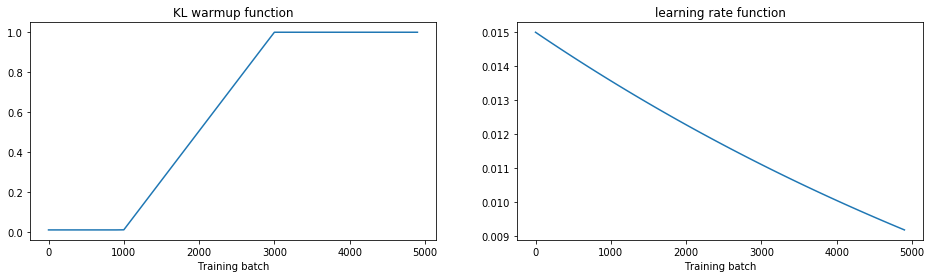

In [25]:
# Plot the warmup function and the learning rate decay function.
plt.figure(figsize=(16,4))
plt.subplot(121)
x = onp.arange(0, num_batches, print_every)
kl_warmup_fun = optimize.get_kl_warmup_fun(lfads_opt_hps)
plt.plot(x, [kl_warmup_fun(i) for i in onp.arange(1,lfads_opt_hps['num_batches'], print_every)]);
plt.title('KL warmup function')
plt.xlabel('Training batch');

plt.subplot(122)
decay_fun = optimizers.exponential_decay(lfads_opt_hps['step_size'],                                                             
                                         lfads_opt_hps['decay_steps'],                                                           
                                         lfads_opt_hps['decay_factor'])                                                          
plt.plot(x, [decay_fun(i) for i in range(1, lfads_opt_hps['num_batches'], print_every)]);
plt.title('learning rate function')
plt.xlabel('Training batch');                                                                                     

### Train the LFADS model

Note that JAX uses it's own setup to handle randomness and seeding the pseudo-random number generators.  You can read about it [here](https://github.com/google/jax/blob/master/README.md#random-numbers-are-different). If you want to modify the LFADS tutorial you *NEED* to understand this. Otherwise, not so big a deal if you are just messing around with LFADS hyperparameters or applying the tutorial to new data.

In [26]:
# Initialize parameters for LFADS
reload(lfads)
seed = onp.random.randint(0, utils.MAX_SEED_INT)
key = random.PRNGKey(seed)
print('Random seed: ', seed)
init_params = lfads.init_params(key, lfads_hps)

Random seed:  7988670


Note that the first loop could take a few minutes to run, because the LFADS model is unrolled, and therefor the JIT (just in time) compilation is slow, and happens "just in time", which is the first training loop iteration. On my computer, the JIT compilation takes a few minutes.

You'll see the loss go up when the KL warmup starts turning on.


In [27]:
reload(lfads)
reload(optimize)
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize.optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,
                            train_data_fun, eval_data_fun)

Batches 1-100 in 36.98 sec, Step size: 0.01485
    Training losses 3823 = NLL 3817 + KL 299.9,3.0 + L2 3.44 + II L2 0.00 + <II> 0.00 
        Eval losses 3816 = NLL 3809 + KL 293.7,2.9 + L2 3.44 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4984, mean 0.5000, max 0.5016, std 0.0016
Batches 101-200 in 4.03 sec, Step size: 0.01470
    Training losses 3811 = NLL 3805 + KL 249.6,2.5 + L2 3.43 + II L2 0.00 + <II> 0.00 
        Eval losses 3803 = NLL 3797 + KL 253.3,2.5 + L2 3.43 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4963, mean 0.5000, max 0.5037, std 0.0037
Batches 201-300 in 4.02 sec, Step size: 0.01456
    Training losses 3805 = NLL 3800 + KL 250.7,2.5 + L2 3.42 + II L2 0.00 + <II> 0.00 
        Eval losses 3800 = NLL 3794 + KL 248.3,2.5 + L2 3.42 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4935, mean 0.5000, max 0.5065, std 0.0065
Batches 301-400 in 4.02 sec, Step size: 0.01441
    Training losses 3797 = NLL 3791 + KL 248.8,2.5 + L2 3.40 + II L2 0.00 + <II> 0.00 
        Eva

Batches 2901-3000 in 4.02 sec, Step size: 0.01111
    Training losses 3825 = NLL 3808 + KL 15.0,14.2 + L2 2.82 + II L2 0.00 + <II> 0.00 
        Eval losses 3809 = NLL 3791 + KL 15.7,14.9 + L2 2.82 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4851, mean 0.5000, max 0.5149, std 0.0149
Batches 3001-3100 in 4.01 sec, Step size: 0.01100
    Training losses 3811 = NLL 3792 + KL 15.3,15.3 + L2 2.80 + II L2 0.00 + <II> 0.00 
        Eval losses 3824 = NLL 3806 + KL 15.1,15.1 + L2 2.80 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4933, mean 0.5000, max 0.5067, std 0.0067
Batches 3101-3200 in 4.03 sec, Step size: 0.01089
    Training losses 3820 = NLL 3802 + KL 14.8,14.8 + L2 2.79 + II L2 0.00 + <II> 0.00 
        Eval losses 3815 = NLL 3797 + KL 15.2,15.2 + L2 2.79 + II L2 0.00 + <II> 0.00 
        Resps: min 0.4936, mean 0.5000, max 0.5064, std 0.0064
Batches 3201-3300 in 4.02 sec, Step size: 0.01078
    Training losses 3813 = NLL 3796 + KL 14.5,14.5 + L2 2.77 + II L2 0.00 + <II> 0.00 
  

Text(0.5,0,'Training batch')

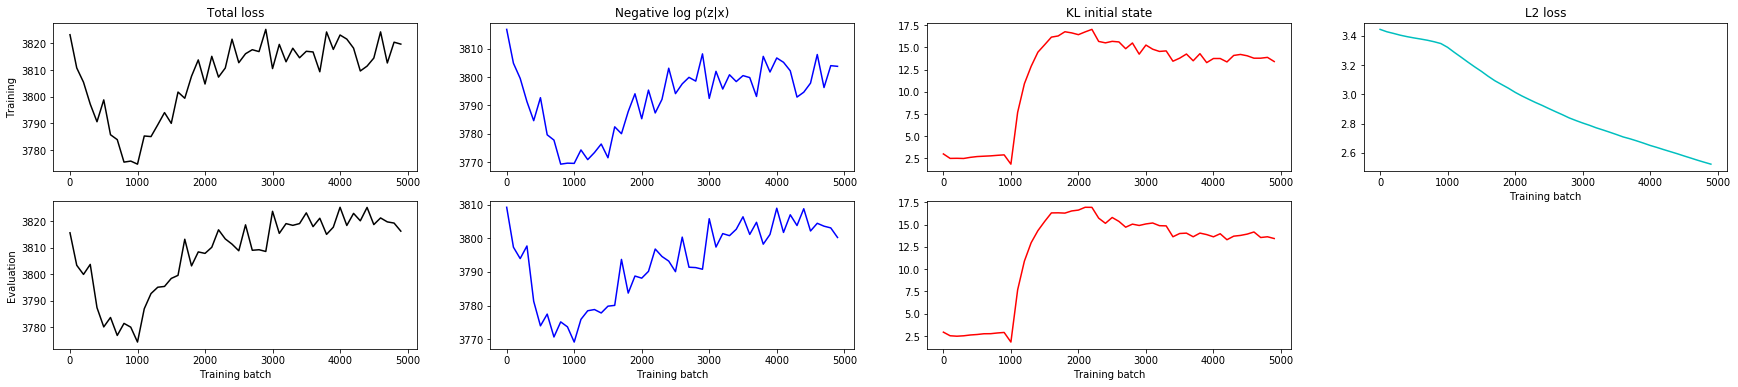

In [28]:
# Plot the training details
x = onp.arange(0, num_batches, print_every)
plt.figure(figsize=(30,6))
plt.subplot(241)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(242)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(243)
plt.plot(x, opt_details['tlosses']['kl'], 'r')
plt.title('KL')
plt.title('KL initial state')
plt.subplot(244)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(245)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(246)
plt.plot(x, opt_details['elosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(247)
plt.plot(x, opt_details['elosses']['kl'], 'r')
plt.xlabel('Training batch')

### Save the LFADS model parameters

In [29]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                 fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)

Saving parameters:  /tmp/lfads/output/trained_params_lfads_gmm_contextual_int_2019-10-22_23:04:28.npz


In [30]:
# After training, you can load these up, after locating the save file.
if False:
    loaded_params = onp.load(network_path, allow_pickle=True)
    trained_params = loaded_params['arr_0'].item()

### LFADS Visualization
To plot the results of LFADS, namely the inferred quantities such as the inferred inputs, factors, or rates, we have to do a sample-and-average operation.  Remember, the latent variables for LFADS are the initial state and the inferred inputs, and they are per-trial *stochastic* codes, even for a *single trial*.  To get good inference for a given trial, we sample a large number of times from these per-trial stochastic latent variables, run the generator forward, and then average all the quantities of interest over the samples. 

If LFADS were linear a linear model, it would be equivalent to do the *much more efficient decode* of the posterior means, that is, just take the mean of the initial state distribution and the mean of the inferred input distribution, and then run the decoder one time. (This, btw, is a great exercise to the tutorial reader: implement posterior-mean decoding in this tutorial.)

Here we use batching and take the 'posterior average' using batch number of samples from the latent variable distributions.

So the main result of this tutorial, the moment you've been waiting for, is the comparison between the true rates of the integrator RNN, and the inferred rates by LFADS, and the true input to the integrator RNN and the inferred inputs given by LFADS.  You can see how well we did by generating lots of trials here.

In [31]:
# Plot two examples of eval trials run through LFADS. I choose two indices, one for each context.
reload(plotting)
reload(lfads)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac

psa_dicts = []
psa_examples = []
eidx_start = 80
nexamples_to_save = 2
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[eidx_start + eidx].astype(np.float32)
    psa_dict = lfads.sample_posterior_and_average_jit(trained_params, lfads_hps, fkey, psa_example, None)
    psa_examples.append(psa_example)
    psa_dicts.append(psa_dict)

bidx:  18512
bidx:  18513


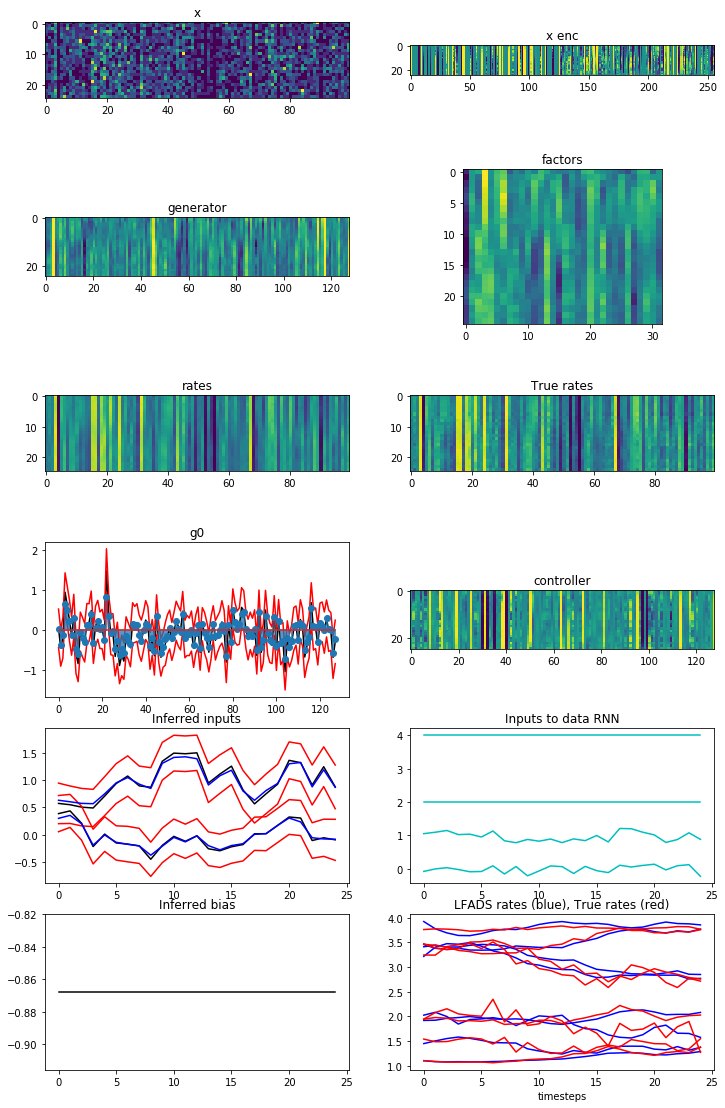

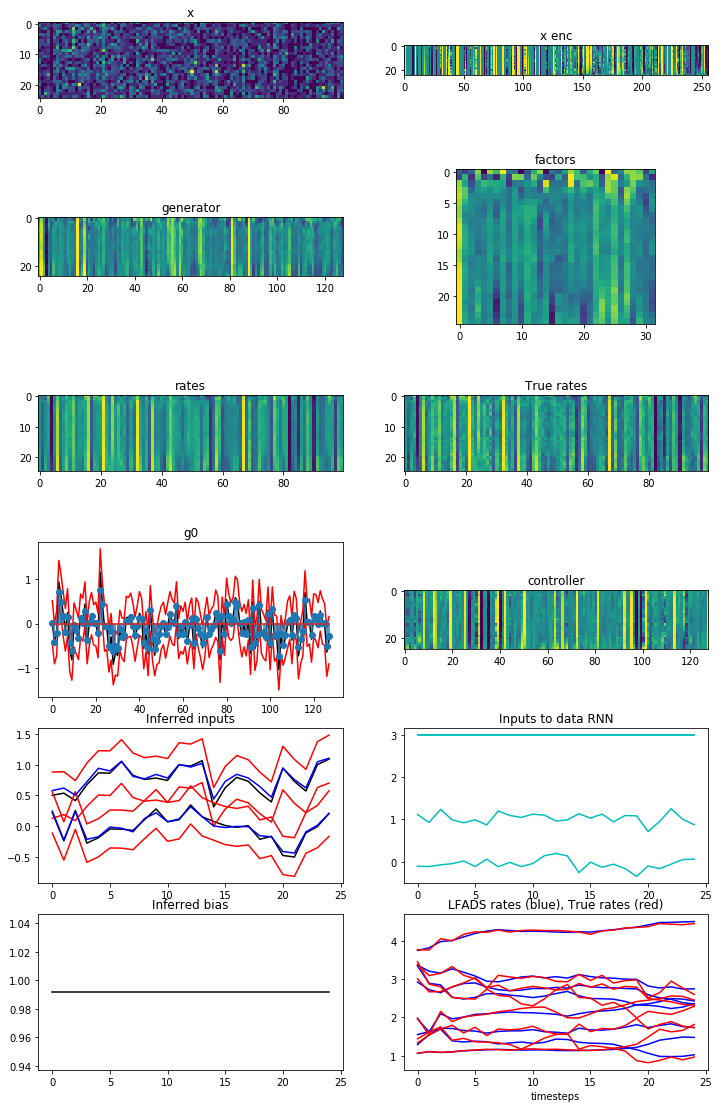

In [32]:
reload(plotting)

for eidx in range(nexamples_to_save):
    data_idx = eval_data_offset + eidx_start + eidx
    f = plotting.plot_lfads(psa_examples[eidx], psa_dicts[eidx],
                            data_dict, data_idx, plot_rescale_fun)

#### Check out the learned priors

Inferred biases:  [-1.3778634] [2.8744433]


Text(0.5,0,'IC#')

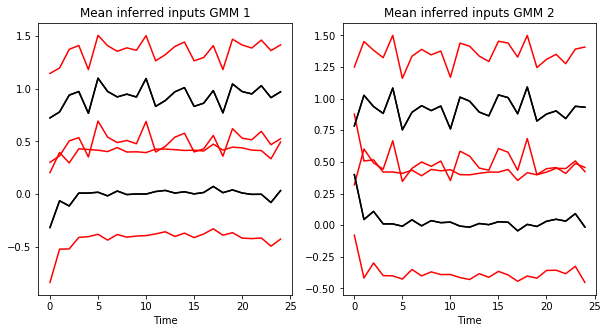

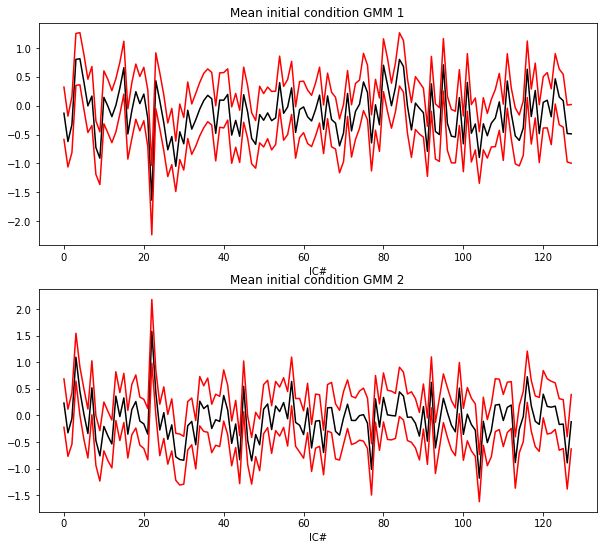

In [33]:
reload(lfads)
ib_prior_mean, g0_prior_mean, ii_prior_mean = \
    lfads.batch_decompose_latent(lfads_hps, trained_params['prior']['means'])
ib_prior_logvar, g0_prior_logvar, ii_prior_logvar = lfads.batch_decompose_latent(lfads_hps, trained_params['prior']['logvars'])

print('Inferred biases: ', ib_prior_mean[0], ib_prior_mean[1])

ii_prior_std = onp.sqrt(onp.exp(ii_prior_logvar))
g0_prior_std = onp.sqrt(onp.exp(g0_prior_logvar))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(ii_prior_mean[0] + onp.expand_dims(np.arange(2), axis=0), 'k')
plt.plot(ii_prior_mean[0] + ii_prior_std[0,:] + onp.expand_dims(np.arange(2), axis=0), 'r')
plt.plot(ii_prior_mean[0] - ii_prior_std[0,:] + onp.expand_dims(np.arange(2), axis=0), 'r')
plt.plot(ii_prior_mean[0] + onp.expand_dims(np.arange(2), axis=0), 'k')
plt.title("Mean inferred inputs GMM 1")
plt.xlabel('Time')

plt.subplot(122)
plt.plot(ii_prior_mean[1] + onp.expand_dims(np.arange(2), axis=0), 'k')
plt.plot(ii_prior_mean[1] + ii_prior_std[1,:] + onp.expand_dims(np.arange(2), axis=0), 'r')
plt.plot(ii_prior_mean[1] - ii_prior_std[1,:] + onp.expand_dims(np.arange(2), axis=0), 'r')
plt.plot(ii_prior_mean[1] + onp.expand_dims(np.arange(2), axis=0), 'k');
plt.title("Mean inferred inputs GMM 2")
plt.xlabel('Time')

plt.figure(figsize=(10,9))
plt.subplot(211)
plt.plot(g0_prior_mean[0], 'k')
plt.plot(g0_prior_mean[0] + g0_prior_std[0], 'r')
plt.plot(g0_prior_mean[0] - g0_prior_std[0], 'r')
plt.title("Mean initial condition GMM 1")
plt.xlabel('IC#')

plt.subplot(212)
plt.plot(g0_prior_mean[1], 'k')
plt.plot(g0_prior_mean[1] + g0_prior_std[1], 'r')
plt.plot(g0_prior_mean[1] - g0_prior_std[1], 'r');
plt.title("Mean initial condition GMM 2")
plt.xlabel('IC#')

And coming back to our example signal, how well does LFADS do on it, compared to the other *much easier to implement* methods? A noticable improvement on inferring the underlying rate.

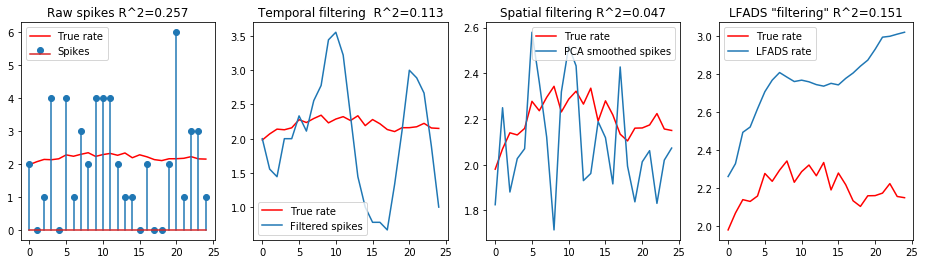

In [34]:
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.plot(my_signal, 'r');
plt.stem(my_signal_spikified);
_, _, r2_spike, _, _ = scipy.stats.linregress(my_signal_spikified, my_signal)
plt.title('Raw spikes R^2=%.3f' % (r2_spike))
plt.legend(('True rate', 'Spikes'));


plt.subplot(142)
plt.plot(my_signal, 'r');
plt.plot(my_filtered_spikes);
_, _, c_tfilt, _, _ = scipy.stats.linregress(my_filtered_spikes, my_signal)
plt.title("Temporal filtering  R^2=%.3f" % (c_tfilt**2));
plt.legend(('True rate', 'Filtered spikes'));

plt.subplot(143)
plt.plot(my_signal, 'r')
plt.plot(my_example_ipca[:,my_example_hidx])
_, _, c_sfilt, _, _ = scipy.stats.linregress(my_example_ipca[:,my_example_hidx], my_signal)
plt.legend(('True rate', 'PCA smoothed spikes'))
plt.title('Spatial filtering R^2=%.3f' % (c_sfilt**2));

plt.subplot(144)
plt.plot(my_signal, 'r')
my_lfads_rate = onp.exp(psa_dict['lograte_t'][:,my_example_hidx])
plt.plot(my_lfads_rate)
_, _, r2_lfads, _, _ = scipy.stats.linregress(my_lfads_rate, my_signal)
plt.legend(('True rate', 'LFADS rate'))
plt.title('LFADS "filtering" R^2=%.3f' % (r2_lfads**2));

That single example can't tell the whole story so let us look at the average. LFADS is much better than spatial averaging across a large set of trials.

Take an average over all the hidden units in 100 evaluation trials.

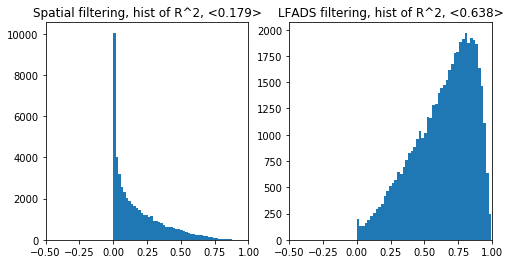

In [35]:
nexamples = 500
r2_sfilts = onp.zeros(nexamples*data_dim)
r2_lfadss = onp.zeros(nexamples*data_dim)
eidx = 0
for bidx in range(nexamples):
    ebidx = eval_data_offset + bidx
    
    # Get the LFADS decode for this trial.
    fkey = random.fold_in(key, bidx)
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    psa_dict = lfads.sample_posterior_and_average_jit(trained_params, lfads_hps, fkey, psa_example, None)
    
    # Get the spatially smoothed trial.
    trial_rates = scale*renormed_data[ebidx, :, :]
    trial_spikes = data_bxtxn[ebidx, :, :]
    spikes_pca = pca.transform(trial_spikes)
    spikes_ipca = pca.inverse_transform(spikes_pca)
    
    for hidx in range(data_dim):
        sig = trial_rates[:, hidx]
        ipca_rate = spikes_ipca[:,hidx]
        lfads_rate = onp.exp(psa_dict['lograte_t'][:,hidx])
        _, _, cc_sfilt, _, _ = scipy.stats.linregress(ipca_rate, sig)
        _, _, cc_lfads, _, _ = scipy.stats.linregress(lfads_rate, sig)

        r2_sfilts[eidx] = cc_sfilt**2
        r2_lfadss[eidx] = cc_lfads**2
        eidx += 1
    
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(r2_sfilts, 50)
plt.title('Spatial filtering, hist of R^2, <%.3f>' % (onp.mean(r2_sfilts)))
plt.xlim([-.5, 1.0])

plt.subplot(122)
plt.hist(r2_lfadss, 50);
plt.title('LFADS filtering, hist of R^2, <%.3f>' % (onp.mean(r2_lfadss)));
plt.xlim([-.5, 1.0]);

### Compare the inferred inputs learned by LFADS to the actual inputs to the integrator RNN. 

Finally, we can look at the average correlation between the inferred inputs and the true inputs to the integrator RNN. The inferred input can be arbitrarily scaled or rotated, so we first compute a linear regression, to scale the inferred input correctly, and then get the $R^2$.

Angle: 90 degrees


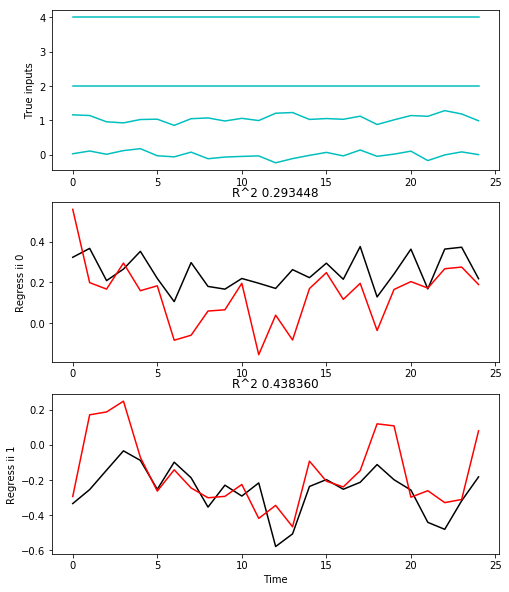

In [36]:
from sklearn import linear_model


# Get the data
bidx = 146
ebidx = eval_data_offset + bidx
fkey = random.fold_in(key, ebidx)
psa_example = eval_data[bidx,:,:].astype(np.float32)
psa_dict = lfads.sample_posterior_and_average_jit(trained_params, lfads_hps, fkey, psa_example, None)
inferred_input = onp.squeeze(psa_dict['ii_t'])
true_input = onp.squeeze(data_dict['inputs'][ebidx])


# Perform the regressions.
coefs = []
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(true_input + onp.expand_dims(onp.arange(4), axis=0),'c')
plt.ylabel('True inputs')
for iidx in range(2):
    ii = inferred_input[:,iidx]
    clf = linear_model.LinearRegression()
    reg = clf.fit(true_input[:, 0:2], ii) # the sensory noise is in first two indices
    r2 = clf.score(true_input[:, 0:2], ii) 
    plt.subplot(3,1,iidx+2)
    plt.plot(onp.sum(true_input[:,0:2] * reg.coef_ + reg.intercept_, axis=1), 'k')
    plt.plot(ii, 'r')
    plt.title('R^2 %f' % r2)
    plt.ylabel('Regress ii %d' % iidx)
    coefs.append(reg.coef_)

plt.xlabel('Time');

coefs = onp.array(coefs)
#print('Regression coefficients: ', coefs)

angle = (onp.arccos(onp.dot(coefs[0,:], coefs[1,:]) 
                    / onp.linalg.norm(coefs[0,:]) 
                    / onp.linalg.norm(coefs[1,:])) 
         / onp.pi * 180)
print("Angle: %.0f degrees" % angle)

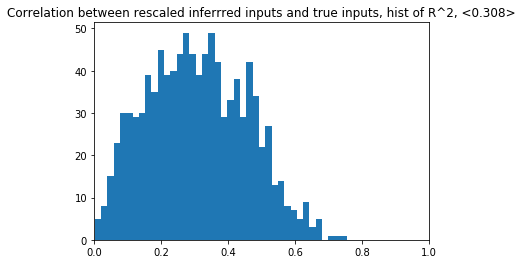

In [37]:
r2_iis = []
nexamples = 500
for bidx in range(nexamples):
    ebidx = eval_data_offset + bidx
    
    # Get the LFADS decode for this trial.
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    fkey = random.fold_in(key, bidx)
    psa_dict = lfads.sample_posterior_and_average_jit(trained_params, lfads_hps, fkey, psa_example, None)
    
    # Get the true input and inferred input
    true_input = onp.squeeze(data_dict['inputs'][ebidx])
    inferred_input = onp.squeeze(psa_dict['ii_t'])
    X = true_input[:, 0:2]
    for iidx in range(2):
        y = inferred_input[:,iidx]
        clf = linear_model.LinearRegression().fit(X, y)
        reg = clf.score(X, y) 
        r2_iis.append(reg)

        
r2_iis = onp.array(r2_iis)

plt.hist(r2_iis, 40)
plt.title('Correlation between rescaled inferrred inputs and true inputs, hist of R^2, <%.3f>' % (onp.mean(r2_iis)))
plt.xlim([0.0, 1.0]);

### Compare the inferred initial state for the LFADS generator to the actual initial state of the integrator RNN.

To finish, we can examine the relationship between the initial condition (h0) of the integrator RNN and the inferred initial condition of the LFADS generator.
The color we use is the readout of the integrator RNN's initial state, so basically the state of the line attractor before further information is presented.  In the integrator RNN example, we made sure to seed these intial states with a various values along the line attractor, so we expect a line of coloration.

In [38]:
ntrials = 500
true_h0s = onp.zeros([ntrials, data_dim])
ic_means = onp.zeros([ntrials, gen_dim])
colors = onp.zeros(ntrials)
for bidx in range(ntrials):
    ebidx = eval_data_offset + bidx
    
    # Get the LFADS decode for this trial.
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    fkey = random.fold_in(key, bidx)
    #psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, fkey, psa_example)
    lfads_results = lfads.forward_pass_jit(trained_params, lfads_hps, fkey, psa_example, 1.0)
    # Get the true initial condition (and the readout of the true h0 for color)
    # Get the inferred input from LFADS
    true_h0s[bidx,:] = data_dict['h0s'][ebidx]
    colors[bidx] = data_dict['outputs'][ebidx][0]
    ic_means[bidx,:] = lfads_results['ic_post_mean']


Text(0.5,0.92,'3D visualziation of LFADS inferred initial generator state.')

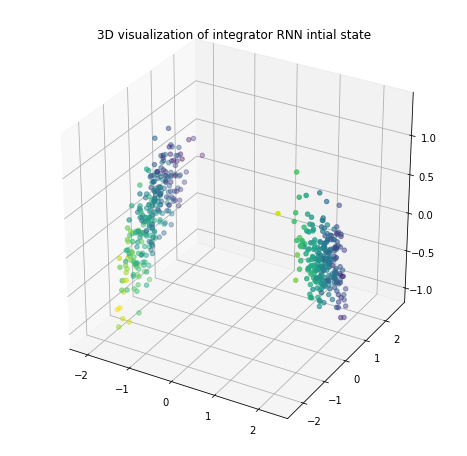

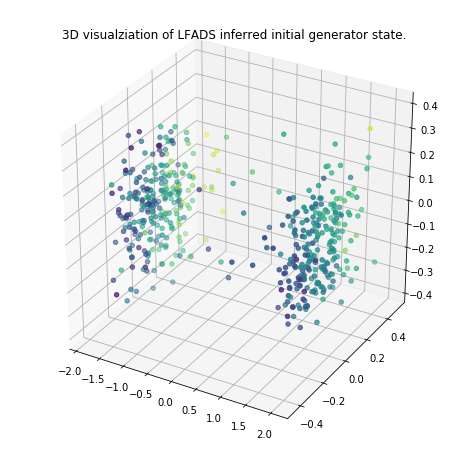

In [39]:
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
h0s_embedded = PCA(n_components=3).fit_transform(true_h0s)
ax.scatter3D(h0s_embedded[:,0], h0s_embedded[:,1], h0s_embedded[:,2], c=colors)
plt.title('3D visualization of integrator RNN intial state')

plt.figure(figsize=(8,8))
plt.subplot(212)
ax = plt.axes(projection='3d')
ic_means_embedded = PCA(n_components=3).fit_transform(ic_means)
ax.scatter3D(ic_means_embedded[:,0], ic_means_embedded[:,1], ic_means_embedded[:,2], c=colors);
plt.title('3D visualziation of LFADS inferred initial generator state.')

#### Of course we can sample from this model to generate new trials.

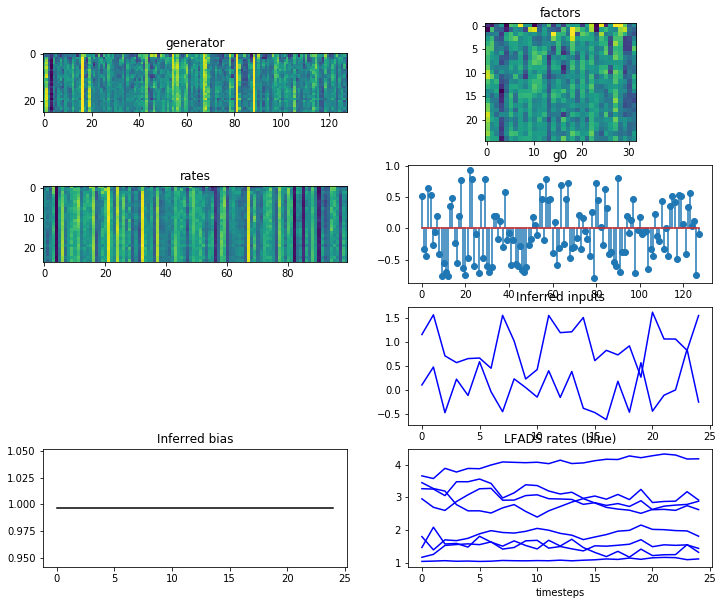

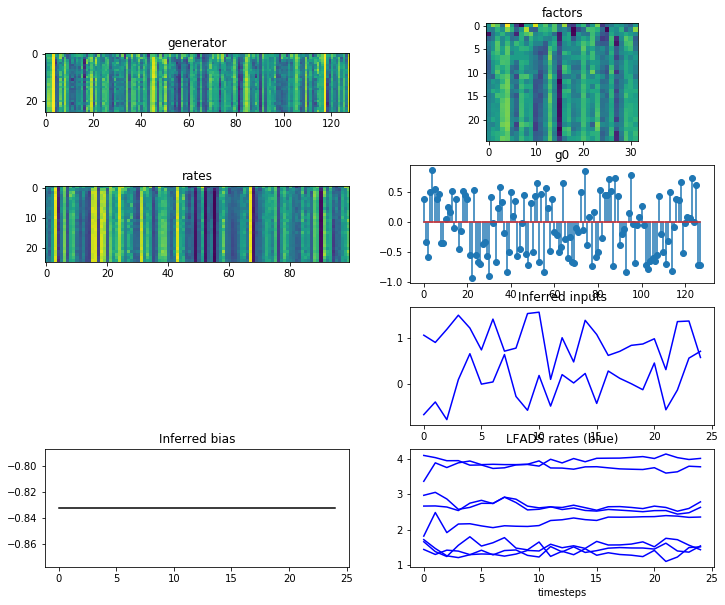

In [41]:
reload(lfads)
reload(plotting)

key = random.PRNGKey(onp.random.randint(10000))
prior_dicts = lfads.sample_prior_jit(trained_params, lfads_hps, key, None)

f = plotting.plot_lfads_from_prior(prior_dicts[0])
f = plotting.plot_lfads_from_prior(prior_dicts[1])